In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

In [ ]:
!unzip -q pythonProject.zip

In [ ]:
train_datagen = ImageDataGenerator(
  rescale=1./255, # 일반화
  rotation_range=90, # 랜덤하게 이미지를 회전 (단위: 도, 0-180)
  width_shift_range=0.1,  # 랜덤하게 이미지를 수평으로 이동 (%)
  height_shift_range=0.1,  # 랜덤하게 이미지를 수직으로 이동 (%)
  horizontal_flip=True # 랜덤하게 이미지를 수평으로 뒤집기
)

test_datagen = ImageDataGenerator(
  rescale=1./255 # 일반화
)

train_gen = train_datagen.flow_from_directory(
  'pythonProject/Training',
  target_size=(224, 224), # (height, width)
  batch_size=32,
  seed=2021,
  class_mode='categorical',
  shuffle=True
)

test_gen = test_datagen.flow_from_directory(
  'pythonProject/Test',
  target_size=(224, 224), # (height, width)
  batch_size=32,
  seed=2021,
  class_mode='categorical',
  shuffle=False
)

Found 1733 images belonging to 3 classes.
Found 102 images belonging to 3 classes.


In [ ]:
from pprint import pprint
pprint(train_gen.class_indices)

{'blackspot': 0, 'normal': 1, 'shortshot': 2}


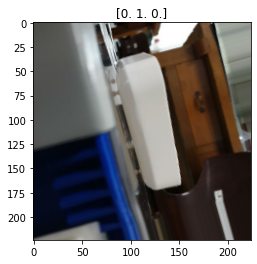

In [ ]:
preview_batch = train_gen.__getitem__(0)

preview_imgs, preview_labels = preview_batch

plt.title(str(preview_labels[0]))
plt.imshow(preview_imgs[0])

In [ ]:
from tensorflow.keras.applications import ResNet50

input = Input(shape=(224, 224, 3))

base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=input, pooling='max')

x = base_model.output
x = Dropout(rate=0.25)(x)
x = Dense(256, activation='relu')(x)
output = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['acc'])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

history = model.fit(
    train_gen,
    validation_data=test_gen, # 검증 데이터를 넣어주면 한 epoch이 끝날때마다 자동으로 검증
    epochs=20, # epochs 복수형으로 쓰기!
    callbacks=[ModelCheckpoint('model.h5', monitor='val_acc', verbose=1, save_best_only=True)]
)

Epoch 1/20
55/55 [==============================] - 41s 604ms/step - loss: 3.1657 - acc: 0.8344 - val_loss: 77.9969 - val_acc: 0.2353

Epoch 00001: val_acc improved from -inf to 0.23529, saving model to model.h5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
55/55 [==============================] - 31s 567ms/step - loss: 0.2773 - acc: 0.9417 - val_loss: 99.5290 - val_acc: 0.2353

Epoch 00002: val_acc did not improve from 0.23529
Epoch 3/20
55/55 [==============================] - 31s 562ms/step - loss: 0.1533 - acc: 0.9619 - val_loss: 2.7398 - val_acc: 0.2353

Epoch 00003: val_acc did not improve from 0.23529
Epoch 4/20
55/55 [==============================] - 31s 564ms/step - loss: 0.4252 - acc: 0.8829 - val_loss: 649.7078 - val_acc: 0.5294

Epoch 00004: val_acc improved from 0.23529 to 0.52941, saving model to model.h5
Epoch 5/20
55/55 [==============================] - 31s 563ms/step - loss: 0.2714 - acc: 0.9077 - val_loss: 3.0137 - val_acc: 0.2353

Epoch 00005: val_acc did not improve from 0.52941
Epoch 6/20
55/55 [==============================] - 31s 562ms/step - loss: 0.1012 - acc: 0.9694 - val_loss: 8.5045 - val_acc: 0.2353

Epoch 00006: val_acc did not improve from 0.52941
Epoch 7/20
55/55 [=============================

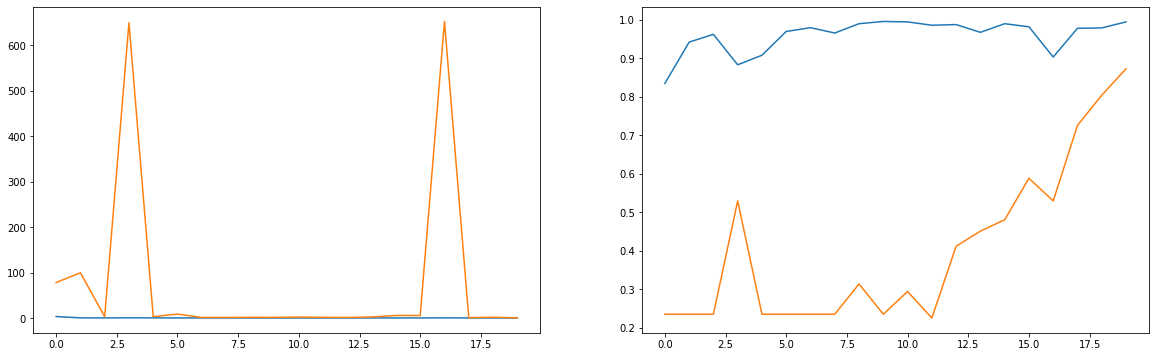

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
axes[0].plot(history.history['loss'])
axes[0].plot(history.history['val_loss'])
axes[1].plot(history.history['acc'])
axes[1].plot(history.history['val_acc'])

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('model.h5')

print('Model loaded!')

Model loaded!


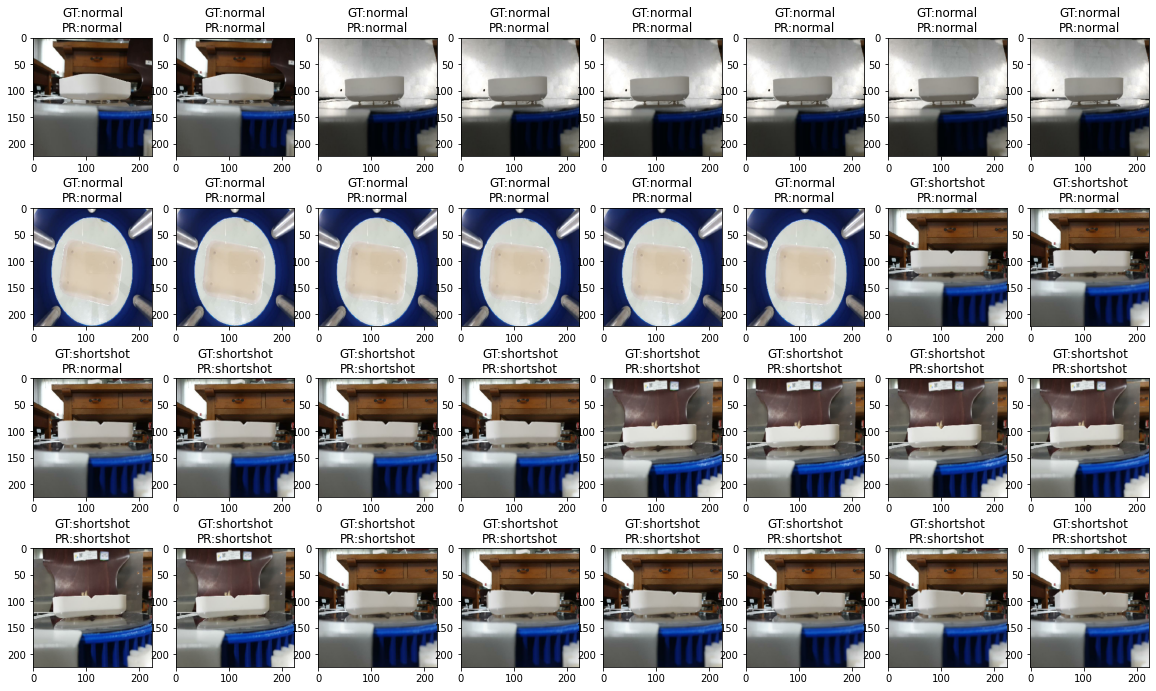

In [ ]:
test_imgs, test_labels = test_gen.__getitem__(2)

y_pred = model.predict(test_imgs)

classes = dict((v, k) for k, v in test_gen.class_indices.items())

fig, axes = plt.subplots(4, 8, figsize=(20, 12))

for img, test_label, pred_label, ax in zip(test_imgs, test_labels, y_pred, axes.flatten()):
  test_label = classes[np.argmax(test_label)]
  pred_label = classes[np.argmax(pred_label)]

  ax.set_title('GT:%s\nPR:%s' % (test_label, pred_label))
  ax.imshow(img)